In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%matplotlib inline

In [2]:
import logging
import pprint
import IPython
from pathlib import Path

import matplotlib.pyplot as plt
import music21
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from double_jig_gen.data import fix_encoding_errors, remove_quoted_strings
from double_jig_gen.tokenizers import ABCTune, CapturingStdout, CapturingStderr
from double_jig_gen.metrics import beats_per_bar

In [3]:
LOGGER = logging.getLogger(__name__)

In [4]:
user_settings = music21.environment.UserSettings()
user_settings["lilypondPath"] = "/afs/inf.ed.ac.uk/user/s08/s0816700/bin/lilypond"
user_settings['showFormat'] = "lilypond"

In [5]:
SCRATCH_NAME = "scratch_ssd"
DATA_HOME = f"/disk/{SCRATCH_NAME}/s0816700/data"
# INPUT_DATA_PATH = f"{DATA_HOME}/raw/folk-rnn/data_v1"
# DATA_IDX_PATH = f"{DATA_HOME}/working/folk-rnn/clean-folk-rnn_source_idx.txt"
INPUT_DATA_PATH = f"{DATA_HOME}/working/thesession.org/all_tunes.abc"
DATA_IDX_PATH = f"{DATA_HOME}/working/thesession.org/tokenized_tunes_source_idx.txt"
TOKENIZED_DATA_PATH = f"{DATA_HOME}/working/thesession.org/tokenized_tunes.txt"


In [6]:
with open(INPUT_DATA_PATH, "r") as fh:
    raw_folkrnn_data = fh.read()
    raw_abc_strings = [tune_str.strip() for tune_str in tqdm(raw_folkrnn_data.split("\n\n"))]

  0%|          | 0/43582 [00:00<?, ?it/s]

In [7]:
len(raw_abc_strings)

43582

In [8]:
with open(DATA_IDX_PATH, "r") as fh:
    clean_data_idx = [int(idx) for idx in fh.read().splitlines()]
len(clean_data_idx)

41933

In [9]:
abc_strings = [
    fix_encoding_errors(
        remove_quoted_strings(raw_abc_strings[idx])
    )
    for idx in tqdm(clean_data_idx)
]

  0%|          | 0/41933 [00:00<?, ?it/s]

In [10]:
print(abc_strings[0])

X: 1
T: Cooley's
Z: Jeremy
S: https://thesession.org/tunes/1#setting1
R: reel
M: 4/4
L: 1/8
K: Edor
|:D2|EBBA B2 EB|B2 AB dBAG|FDAD BDAD|FDAD dAFD|
EBBA B2 EB|B2 AB defg|afec dBAF|DEFD E2:|
|:gf|eB B2 efge|eB B2 gedB|A2 FA DAFA|A2 FA defg|
eB B2 eBgB|eB B2 defg|afec dBAF|DEFD E2:|


In [11]:
print(abc_strings[-1])

X: 1
T: Erin, The Tear And The Smile
Z: R. Rassweiler
S: https://thesession.org/tunes/20903#setting41593
R: waltz
M: 3/4
L: 1/8
K: Gmaj
D2E2F2|G3AB2|D2E2F2|G6:|
|: B2B2B2|c3E E2|B2B2A2|G3ED2|
d2 cBA2|G3A!fermata!B2|D2E2F2|G6||


In [22]:
# %lprun -f music21.stream.makeNotation.makeBeams -f music21.stream.Stream.makeBeams -f music21.abcFormat.translate.abcToStreamPart -f music21.abcFormat.translate.abcToStreamScore -f music21.converter.parse -f ABCTune.__init__ ABCTune(abc_strings[-1])

In [28]:
tunes = [
    ABCTune(
        abc_string,
        # pianoroll_divisions_per_quarternote=12,
        # min_pitch=0,
        # min_time=0,
        # transpose_to_pitchclass="C"
    )
    for abc_string in tqdm(abc_strings)
]

  0%|          | 0/41933 [00:00<?, ?it/s]

In [25]:
# tunes = [
#     ABCTune(
#         abc_string,
#         # pianoroll_divisions_per_quarternote=12,
#         # min_pitch=0,
#         # min_time=0,
#         # transpose_to_pitchclass="C"
#     )
#     for abc_string in tqdm(abc_strings[:1000])
# ]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
base_path = f"{DATA_HOME}/working/thesession.org/music21"

In [171]:
for ii, tune in tqdm(enumerate(tunes)):
    stream_freezer = music21.freezeThaw.StreamFreezer(tune.abc_music21)
    stream_freezer.write(fmt='jsonpickle', fp=f"{base_path}/{ii}.json")

0it [00:00, ?it/s]

In [27]:
# # This is 4x slower than reading normally :facepalm:
# music_21_items = [
#     music21.converter.thaw(path)
#     for path in tqdm(sorted(Path(base_path).iterdir(), key=lambda x: f"{str(x.stem):0>5}"))
# ]   

  0%|          | 0/41933 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Get tune level info

In [87]:
def get_part(tune):
    stream = tune.abc_music21
    parts = stream.parts
    nr_parts = len(parts)
    if nr_parts > 1:
        part = None
    else:
        part = parts[0]
    return pd.Series(dict(nr_parts=nr_parts, part=part)) 

In [88]:
part_df = pd.Series(tunes).apply(get_part)

In [89]:
part_df.nr_parts = part_df.nr_parts.astype(int)

In [90]:
part_df.index.name = "tune_idx"

In [91]:
part_df["raw_tune_idx"] = clean_data_idx
# part_df["raw_tune_idx"] = clean_data_idx[:1000]

## Drop tunes with more than one part

In [92]:
assert (part_df.nr_parts > 0).all()

In [93]:
has_gt_1_part = part_df.nr_parts > 1

In [94]:
gt_1_part_tunes = [tunes[idx] for idx in part_df.loc[has_gt_1_part].index]
gt_1_part_raw_abc_strings = [raw_abc_strings[idx] for idx in part_df.loc[has_gt_1_part, "raw_tune_idx"]]

In [95]:
part_df.loc[has_gt_1_part, ["nr_parts", "raw_tune_idx"]].reset_index()

,tune_idx,nr_parts,raw_tune_idx
0,119,2,121
1,155,2,157
2,2278,12,2308
3,3225,16,3262
4,3226,16,3263
...,...,...,...
83,39244,2,40668
84,39425,2,40863
85,39801,2,41281
86,41280,12,42889


In [96]:
idx = 0
display(gt_1_part_tunes[idx])
print(gt_1_part_raw_abc_strings[idx])

ABCTune(
    abc_data='X: 11\nT: Butterfly, The\nZ: benhockenberry\nS: https://thesession.org/tunes/10#setting37187\nR: slip jig\nM: 9/8\nL: 1/8\nK: Emin\nV:1\nB,2E G2A|^A2B A2=A G3B,3D3|E3E3E3 FG/FE/D3|\nE3E3E3 DE/DB,/ A,3|B,3B,3B,3 B,2E G2A||\n^A2B A2=A G3B,3D3|E3E3E3 DE/DB,/ A,3|\nB,3B,3B,3 FG/FE/D3|E3E3E3z6||\ne2g z2e c3 A2B c2^c|d2fz2d B3 G2A ^A2B|\nc2e z2c A3 F2G A2^A|B2^A B2c d3 d2^cd2^d|\ne2g z2e c3 A2B c2^c|d2fz2d B3 G2A ^A2B|\nc2e z2c A3 F2A d2c|B3B3B3 B,2E G2A||\nV:2\nz6|B2E G2E F3 B2E FED | B2E G2E F3 BdB AFD |\nB2E G2E F3 B2E FED | B2E G2E F3 BdB AFD ||\nB2d e2f g3 B2e dBA | B2d e2f g2a bge dBA |\nB2d e2f g3 B2e dBA | B2d e2f g2a bge dBA ||\nB3 B2A G2A BAB dBA | B3 B2A G2A g2e dBA |\nB3 B2A G2A BAB dBA | B3 B2A G2A g2e dBA |\nB3 B2A G2A BAB dBA | B3 B2A G2A g2e dBA |\nB3 B2A G2A BAB dBA | B3 B2A G2A g2e dBA ||',
    pianoroll_divisions_per_quarternote=12,
    min_pitch=None,
    min_time=None,
    transpose_semitones=None,
    transpose_to_pitchclass=None,
)

X: 11
T: Butterfly, The
Z: benhockenberry
S: https://thesession.org/tunes/10#setting37187
R: slip jig
M: 9/8
L: 1/8
K: Emin
V:1
B,2E G2A|"Em"^A2B A2=A G3"Bm7"B,3D3|"Em"E3E3E3 "Bm7"FG/FE/D3|
"Em"E3E3E3 "Bm7"DE/DB,/ A,3|"Em"B,3B,3B,3 "Bm7"B,2E G2A||
"Em"^A2B A2=A G3"Bm7"B,3D3|"Em"E3E3E3 "Bm7"DE/DB,/ A,3|
"Em"B,3B,3B,3 "Bm7"FG/FE/D3|"Em"E3E3E3z6||
"Cmaj7"e2g z2e c3 "Am7"A2B c2^c|"Bm7"d2fz2d B3 "Em7"G2A ^A2B|
"Am7"c2e z2c A3 "D7"F2G A2^A|"Gmaj7"B2^A B2c d3 d2^cd2^d|
"Cmaj7"e2g z2e c3 "Am7"A2B c2^c|"Bm7"d2fz2d B3 "Em7"G2A ^A2B|
"Am7"c2e z2c A3 "D7"F2A d2c|"C#m7b5"B3B3B3 "B7b5"B,2E G2A||
V:2
z6|B2E G2E F3 B2E FED | B2E G2E F3 BdB AFD |
B2E G2E F3 B2E FED | B2E G2E F3 BdB AFD ||
B2d e2f g3 B2e dBA | B2d e2f g2a bge dBA |
B2d e2f g3 B2e dBA | B2d e2f g2a bge dBA ||
B3 B2A G2A BAB dBA | B3 B2A G2A g2e dBA |
B3 B2A G2A BAB dBA | B3 B2A G2A g2e dBA |
B3 B2A G2A BAB dBA | B3 B2A G2A g2e dBA |
B3 B2A G2A BAB dBA | B3 B2A G2A g2e dBA ||


In [97]:
single_part_df = part_df.loc[part_df["nr_parts"] == 1]

## Drop null tunes

In [98]:
tune_is_null = single_part_df.part.isnull()
single_part_df[tune_is_null]

,nr_parts,part,raw_tune_idx
tune_idx,,,


## Drop tunes with no bars

In [99]:
no_measures = single_part_df.part.apply(
    lambda part: len(part.getElementsByClass(music21.stream.Measure)) == 0
)

In [100]:
no_measures.sum()

6

In [101]:
single_part_df[no_measures]

,nr_parts,part,raw_tune_idx
tune_idx,,,
8949,1,"[<music21.clef.TrebleClef>, A major, <music21....",9050
11567,1,"[<music21.clef.TrebleClef>, e minor, <music21....",11719
22398,1,"[<music21.clef.TrebleClef>, D major, <music21....",22851
34894,1,"[<music21.clef.TrebleClef>, G major, <music21....",35969
35742,1,"[<music21.clef.TrebleClef>, A major, <music21....",36860
35951,1,"[<music21.clef.TrebleClef>, C dorian, <music21...",37087


In [102]:
print(raw_abc_strings[312])

X: 1
T: Off To California
Z: Jeremy
S: https://thesession.org/tunes/30#setting30
R: hornpipe
M: 4/4
L: 1/8
K: Gmaj
|:GFGB AGED|GBdg e2df|gfgd edBG|ABAG E2DE|
|G2GB AGED|GBdg e2df|gfgd edBG|ABAF G4:|
|:gfeg fedf|edef edBd|gfgd edBG|ABAG EDEF|
|GFGB AGED|GBdg e2df|gfgd edBG|ABAF G4:|


In [103]:
single_part_df.loc[302].part.show("text")

{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.bar.Repeat direction=start>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of A dorian>
    {0.0} <music21.meter.TimeSignature 6/8>
    {0.0} <music21.note.Note A>
    {1.0} <music21.note.Note B>
    {1.5} <music21.note.Note C>
    {2.0} <music21.note.Note B>
    {2.5} <music21.note.Note A>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 7 offset=21.0>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 8 offset=24.0>>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 16 offset=48.0>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 17 offset=51.0>>
{3.0} <music21.stream.Measure 1 offset=3.0>
    {0.0} <music21.note.Note E>
    {0.5} <music21.note.Note A>
    {1.0} <music21.note.Note B>
    {1.5} <music21.note.Note C>
    {2.0} <music21.note.Note B>
    {2.5} <music21.note.Note A>
{6.0} <music21.stream.Measure 2 offset=6.0>
    {0.0} <music21.note.Note G>

In [104]:
print(raw_abc_strings[727])

X: 6
T: Mason's Apron, The
Z: ceolachan
S: https://thesession.org/tunes/74#setting12550
R: reel
M: 4/4
L: 1/8
K: Amaj
[e2G2] [e2G2]- [e2G2] eg | aA (3AAA cBAF | EFAB cABc | dB (3BBB dcBA |
GABc defg | aA (3AAA cBAF | EFAB cABc | dcde (3fga gf | edcB Aefg | 
aA (3AAA cBAF | EFAB cABc | dBcd ecde | fdef gefg |
aA (3AAA cBAF | EFAB cABc | dcde (3fga gf | edcB A |]
cA (3AAA fAeA | ceAc fedc | dB (3BBB gBfB | dfBd gfed |
cA (3AAA fAeA | ceAc fedc | Bcde fagf | edcB AGAB |
cA (3AAA fAeA | ceAc fedc | dB (3BBB gBfB | dfBd gfed | 
cA (3AAA fAeA | ceAc fedc | Bcde fbbg | afec A |]
c2 ec fcec | (3ccc ec fcec | d2 fd gdfd | (3ddd bd gdfd |
c2 ac gcfc | (3ccc ac gcfc | dcde (3fga gf | edcB AGAB |
c2 ac gcfc | c[ac]-[ac]c gcfc | d[gd]-[gd]d fded | d[bd]-[bd]d fded | 
c[ac]-[ac]c gcfc | (3ccc ac gcfc | dcde (3fga gf | edcB A |]
ae (3eee aefg | a2 ga f=f^fa | bf (3fff bfga | ^abab gede |
ae (3eee aefg | a2 ga fece | ~a3 f ecAc | B_B=Bc Aefg |
ae (3eee aefg | a2 ga f=f^fa | bf (3fff bfga | ^abab gede 

In [105]:
single_part_df.loc[710].part.show("text")

{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of b minor>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note B>
    {0.5} <music21.note.Note A>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 4 offset=13.0>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 5 offset=17.0>>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 9 offset=33.0>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 10 offset=37.0>>
{1.0} <music21.stream.Measure 1 offset=1.0>
    {0.0} <music21.bar.Repeat direction=start>
    {0.0} <music21.note.Note F#>
    {0.5} <music21.note.Note B>
    {1.0} <music21.note.Note B>
    {1.5} <music21.note.Note A>
    {2.0} <music21.note.Note B>
    {3.0} <music21.note.Note A>
    {3.5} <music21.note.Note B>
{5.0} <music21.stream.Measure 2 offset=5.0>
    {0.0} <music21.note.Note C#>
    {0.5} <music21.note.Note B>
    {1.0} <music21.note.Note A>

:point_up: is that a music21 bug?

In [106]:
single_part_df = single_part_df.loc[~no_measures]

## Drop tunes with less than 6 bars

```
T: Red Skies
M: 12/8
L: 1/8
K: Ador
|: EBE c2d z2e ^dBA | EBE c2d D2E FED | |: AGF G2A-AGB AFD | BAB dBd e2f-fg2 |AB=c B2A-ABe dBA |1 EDE GEG AB=c BAG :|2 ez2 {^d}e3 edB AGF ||
```

In [107]:
lt_6_measures = single_part_df.part.apply(
    lambda part: len(part.getElementsByClass(music21.stream.Measure)) < 6
)

In [108]:
single_part_df[lt_6_measures]

,nr_parts,part,raw_tune_idx
tune_idx,,,
409,1,"[[<music21.clef.TrebleClef>, A dorian, <music2...",413
410,1,"[[<music21.clef.TrebleClef>, A dorian, <music2...",414
501,1,"[[<music21.bar.Repeat direction=start>, <music...",505
502,1,"[[<music21.bar.Repeat direction=start>, <music...",506
504,1,"[[<music21.clef.TrebleClef>, e minor, <music21...",508
...,...,...,...
29294,1,"[[<music21.clef.TrebleClef>, D major, <music21...",30046
32636,1,"[[<music21.clef.TrebleClef>, A dorian, <music2...",33598
35178,1,"[[<music21.bar.Repeat direction=start>, <music...",36270


In [109]:
print(
    "\n\n".join(
        raw_abc_strings[idx] for idx in single_part_df.loc[lt_6_measures, "raw_tune_idx"]
    )
)

X: 2
T: Guns Of The Magnificent Seven, The
Z: Will Harmon
S: https://thesession.org/tunes/40#setting12455
R: reel
M: 4/4
L: 1/8
K: Ador
|egdb A2 eg|dBGA (3Bcd eB|dBAa4 f||gedB BAA2|

X: 3
T: Guns Of The Magnificent Seven, The
Z: Dr. Dow
S: https://thesession.org/tunes/40#setting12456
R: reel
M: 4/4
L: 1/8
K: Ador
|egdB GA (3Bcd|eBdB a3g|(3efg dB BAA2:|

X: 2
T: Kid On The Mountain, The
Z: ceolachan
S: https://thesession.org/tunes/52#setting12486
R: slip jig
M: 9/8
L: 1/8
K: Emin
P: 6
|: B,EE eBG E2 E | B,EE EFG AFD | B,EE EBG E2 G/A/ | BAG FAG FED :|

X: 3
T: Kid On The Mountain, The
Z: ceolachan
S: https://thesession.org/tunes/52#setting12487
R: slip jig
M: 9/8
L: 1/8
K: Emin
P: 6
|: B,EE E2 G E2 E | B,2 E E2 G AF/E/D | B,EE EGG E2 G | B2 G A2 G FED :|

X: 5
T: Kid On The Mountain, The
Z: Pippa
S: https://thesession.org/tunes/52#setting12489
R: slip jig
M: 9/8
L: 1/8
K: Emin
B,EE EDE G2 E | B,EE EDE DB,A, |B,EB, EDE G2 A | BAG FAG FED :||

X: 3
T: Mountain Road, The
Z: fidicen
S: http

In [110]:
single_part_df = single_part_df.loc[~lt_6_measures]

## Extract objects of interest

In [111]:
def extract_objects_from_part(part):
    return pd.Series(
        dict(
            time_signatures = part.getTimeSignatures(
                returnDefault=False, sortByCreationTime=True
            ),
            keys = [key for key in part.recurse().getElementsByClass(music21.key.Key)],
            measures = [measure for measure in part],
            has_chords = part.hasElementOfClass(music21.chord.Chord),
        )
    ) 

In [112]:
part_objects = single_part_df["part"].apply(extract_objects_from_part)

## Extract info from object

In [113]:
def get_key_info(keys):
    nr_keys = len(keys)
    first_key = None
    key_name = None
    key_nr_sharps = None
    if nr_keys > 0:
        first_key = keys[0]
        key_name = first_key.name
        key_nr_sharps = first_key.sharps
    return nr_keys, first_key, key_name, key_nr_sharps

In [114]:
key_info = pd.DataFrame(
    part_objects["keys"].map(get_key_info).tolist(),
    columns=["nr_keys", "first_key", "key_name", "key_nr_sharps"],
    index=part_objects.index,
)
key_info

,nr_keys,first_key,key_name,key_nr_sharps
tune_idx,,,,
0,1,E dorian,E dorian,2
1,1,e minor,E minor,1
2,1,e minor,E minor,1
3,1,E dorian,E dorian,2
4,1,E dorian,E dorian,2
...,...,...,...,...
41928,1,D major,D major,2
41929,1,F major,F major,-1
41930,1,D major,D major,2


In [115]:
no_keys = (key_info["nr_keys"] < 1) | key_info["nr_keys"].isnull()
part_objects.loc[no_keys]

,time_signatures,keys,measures,has_chords
tune_idx,,,,


In [116]:
# print(tunes[tune_idx].abc_data)

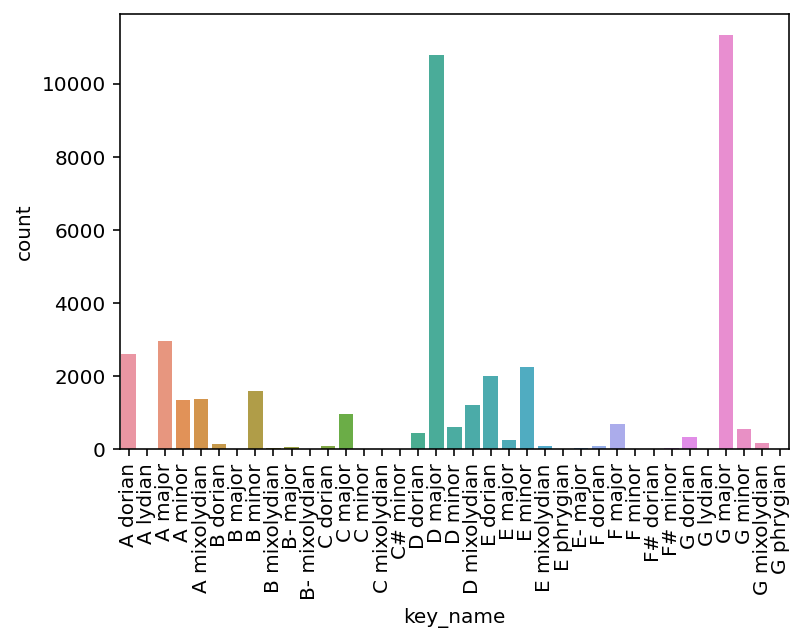

In [144]:
plt.figure()
sns.countplot(x=key_info["key_name"], order=np.sort(key_info["key_name"].unique()))
plt.xticks(rotation="vertical")
plt.show()

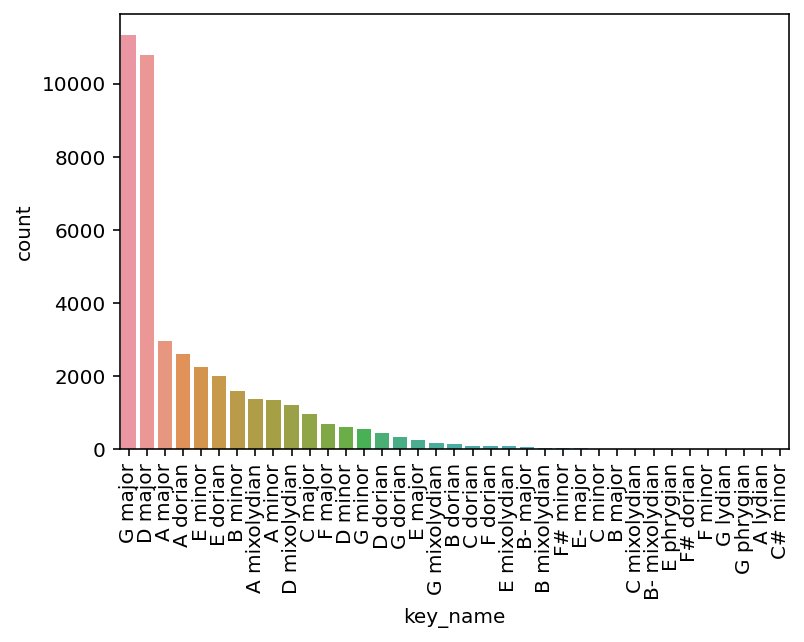

In [145]:
plt.figure()
sns.countplot(x=key_info["key_name"], order=key_info["key_name"].value_counts().index)
plt.xticks(rotation="vertical")
plt.show()

In [118]:
def get_time_signature_info(time_signatures):
    nr_ts = len(time_signatures)
    first_ts = None
    ts_str = None
    ts_numerator = None
    ts_denominator = None
    if nr_ts > 0:
        ts = time_signatures[0]
        ts_str = ts.ratioString
        ts_numerator = ts.numerator
        ts_denominator = ts.denominator
    return nr_ts, ts, ts_str, ts_numerator, ts_denominator

In [119]:
time_signature_info = pd.DataFrame(
    part_objects["time_signatures"].map(get_time_signature_info).tolist(),
    columns=[
        "nr_time_signatures",
        "first_time_signature",
        "time_signature_str",
        "time_signature_numerator",
        "time_signature_denominator"
    ],
    index=part_objects.index,
)
time_signature_info

,nr_time_signatures,first_time_signature,time_signature_str,time_signature_numerator,time_signature_denominator
tune_idx,,,,,
0,1,<music21.meter.TimeSignature 4/4>,4/4,4,4
1,1,<music21.meter.TimeSignature 4/4>,4/4,4,4
2,1,<music21.meter.TimeSignature 4/4>,4/4,4,4
3,1,<music21.meter.TimeSignature 4/4>,4/4,4,4
4,1,<music21.meter.TimeSignature 4/4>,4/4,4,4
...,...,...,...,...,...
41928,1,<music21.meter.TimeSignature 6/8>,6/8,6,8
41929,1,<music21.meter.TimeSignature 6/8>,6/8,6,8
41930,1,<music21.meter.TimeSignature 3/4>,3/4,3,4


In [120]:
no_ts = (time_signature_info["nr_time_signatures"] < 1) | time_signature_info["nr_time_signatures"].isnull()
part_objects.loc[no_ts]

,time_signatures,keys,measures,has_chords
tune_idx,,,,


In [121]:
time_signature_info["time_signature_str"]

tune_idx
0        4/4
1        4/4
2        4/4
3        4/4
4        4/4
        ... 
41928    6/8
41929    6/8
41930    3/4
41931    4/4
41932    3/4
Name: time_signature_str, Length: 41774, dtype: object

In [152]:
ts_counts = time_signature_info.groupby(["time_signature_denominator", "time_signature_numerator", "time_signature_str"]).size()
ts_counts

time_signature_denominator  time_signature_numerator  time_signature_str
2                           2                         2/2                       7
                            3                         3/2                     270
4                           2                         2/4                    3699
                            3                         3/4                    3166
                            4                         4/4                   21114
                            5                         5/4                      11
                            6                         6/4                      21
                            9                         9/4                       2
8                           5                         5/8                      21
                            6                         6/8                   10915
                            7                         7/8                      65
                         

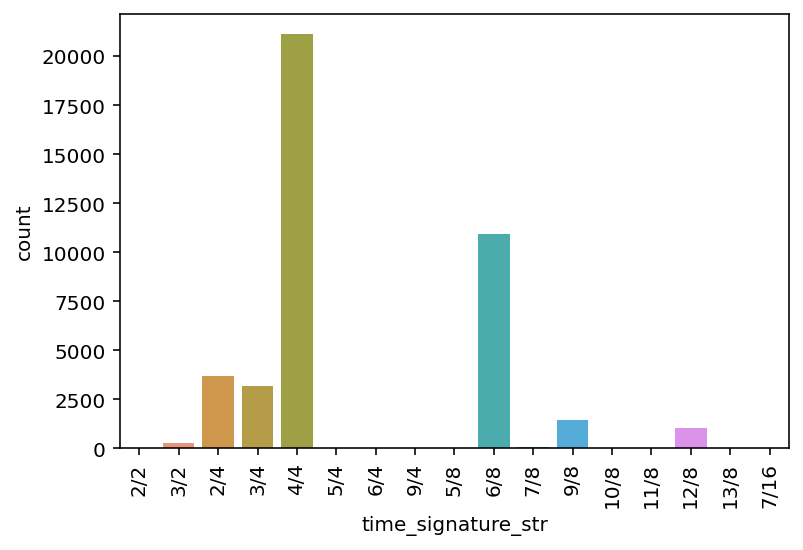

In [157]:
plt.figure()
sns.countplot(x=time_signature_info["time_signature_str"], order=ts_counts.index.get_level_values("time_signature_str"))
plt.xticks(rotation="vertical")
plt.show()

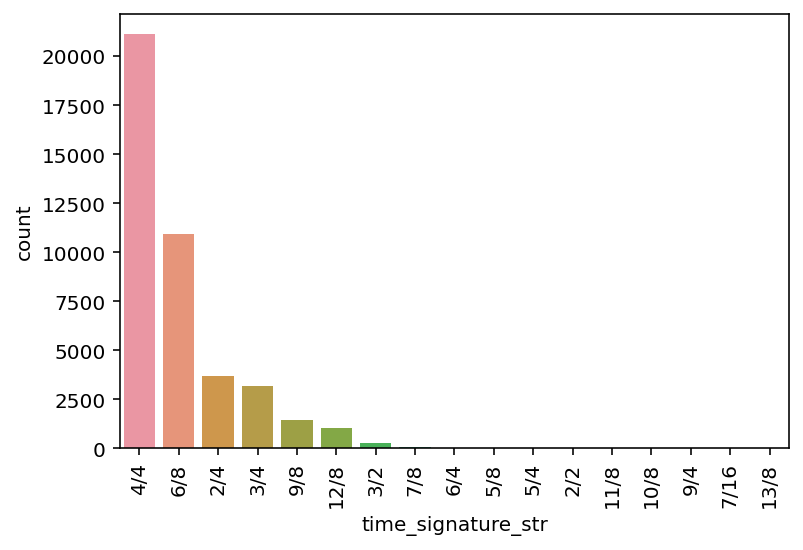

In [158]:
plt.figure()
sns.countplot(x=time_signature_info["time_signature_str"], order=time_signature_info["time_signature_str"].value_counts().index)
plt.xticks(rotation="vertical")
plt.show()

In [123]:
# def get_sections(part):
#     sections = []
#     current_section = []
#     previous_measure_nr = -1
#     try:
#         measure_map = music21.repeat.Expander(part).measureMap()
#     except music21.repeat.ExpanderException:
#         return []
#     except AttributeError:
#         return []
#     for measure_nr in measure_map:
#         if previous_measure_nr > measure_nr or current_section in sections:
#             sections.append(current_section)
#             current_section = [measure_nr]
#         else:
#             current_section.append(measure_nr)
#         previous_measure_nr = measure_nr
#     else:
#         sections.append(current_section)
#     sections = [tuple(section) for section in sections]
#     return sections


# def label_sections_and_get_form(sections):
#     section_id = {}
#     section_nr = 0
#     form = []
#     try:
#         for section in sections:
#             if section not in section_id:
#                 section_id[section] = section_nr
#                 section_nr += 1
#             form += [section_id[section]]
#     #     form = "".join([string.ascii_uppercase[section_nr] for section_nr in form]
#     except Exception as e:
#         print(sections)
#         raise e
#     return str(form), section_id

In [124]:
# form_df = part_df["part"].loc[:1000].apply(
#     lambda part: label_sections_and_get_form(
#         get_sections(part)
#     )
# )

In [125]:
# def get_sections(measures):
#     sections = []
#     durations = []
#     for measure in measures:
#         if measure
#     return sections

# def get_measure_info(measures):
#     # has anacrusis
#     # anacrusis match?
#     # TODO: get the expected bar durations vs the expected (account for anacrusis)
    
#     return [(measure.barDuration.quarterLength, measure.duration.quarterLength) for measure in measures]
    

In [126]:
def get_section_information(part):
    def write_section(sections, section, how_many):
        if (len(section["measures"]) != 0) and (how_many is not None):
            section["how_many"] = how_many
            sections.append(section)
        section = {"measures": [], "measure_repeat_nr": [], "how_many": None}
        return sections, section
    def append_measure(section, measure, measure_repeat_nr=0):
        if len(
            measure.getElementsByClass(
                [music21.note.Note, music21.note.Rest, music21.chord.Chord]
            )
        ) == 0:
            # don't append, the measure is empty
            return section
        section["measures"].append(measure)
        section["measure_repeat_nr"].append(measure_repeat_nr)
        return section
    def has_barline(measure, side, must_be_repeat):
        if side == "left":
            bar = measure.leftBarline
        elif side == "right":
            bar = measure.rightBarline
        else:
            raise ValueError()
        if bar:
            if must_be_repeat:
                return isinstance(bar, music21.bar.Repeat) 
            else:
                return True
        else:
            return False
    repeat_measures = {}
    sections = []
    section = {"measures": [], "measure_repeat_nr": [], "how_many": None}
    previous_bar_ended_section = False
    ignored_classes = (
        music21.spanner.Slur,
        music21.key.Key,
#         music21.clef.TrebleClef,
#         music21.meter.TimeSignature,
#         music21.chord.Chord,
#         music21.note.Note,
    )
    how_many = None
    must_be_repeat = False
    for obj in part:
        if isinstance(obj, music21.spanner.RepeatBracket):
            measure_repeat_nr = int(obj.number)  # this will fail if it's not an int, see .getNumberList()
            for measure in obj.getSpannedElements():
                repeat_measures[measure] = measure_repeat_nr
        elif isinstance(obj, music21.stream.Measure):
            measure = obj
            if measure in repeat_measures:
                measure_repeat_nr = repeat_measures[measure]
                how_many = measure_repeat_nr
                del repeat_measures[measure]
                if len(repeat_measures) == 0:
                    previous_bar_ended_section = True
                elif has_barline(measure, side="right", must_be_repeat=False):
                    previous_bar_ended_section = True
                section = append_measure(section, measure, measure_repeat_nr)
            elif has_barline(measure, side="right", must_be_repeat=must_be_repeat):
#                 if not measure.rightBarline.type in ["double", "final"]:
#                     print(measure.rightBarline.type)
#                     print(measure.rightBarline)
                # TODO: handle case where previous_bar_ended_section is already true
                previous_bar_ended_section = True
                if isinstance(measure.rightBarline, music21.bar.Repeat):
                    rb_times = measure.rightBarline.times
                    if rb_times is None:
                        rb_times = 2
                else:
                    rb_times = None
                if (how_many is None or how_many == 1) and rb_times is not None:
                    how_many = rb_times
                section = append_measure(section, measure, measure_repeat_nr=0)
            elif has_barline(measure, side="left", must_be_repeat=must_be_repeat) or previous_bar_ended_section:
                previous_bar_ended_section = False
                sections, section = write_section(sections, section, how_many)
                section = append_measure(section, measure, measure_repeat_nr=0)
                how_many = None
                if isinstance(measure.leftBarline, music21.bar.Repeat):
                    must_be_repeat = True
                else:
                    must_be_repeat = False
            else:
                previous_bar_ended_section = False
                if how_many is None:
                    how_many = 1
                section = append_measure(section, measure, measure_repeat_nr=0)
        elif isinstance(obj, ignored_classes):
            pass
        else:
            raise(ValueError(f"Not expecting {type(obj)}: {obj}"))
    else:
        sections, section = write_section(sections, section, how_many)
    if len(sections) == 0:
        LOGGER.warning(f"{part} returned nothing:\n{part.show('text')}")
        sections = [{"measures": [], "measure_repeat_nr": [], "how_many": None}]
    return sections

In [127]:
# tune_932 = """T: Thady Regan
# M: 2/4
# L: 1/8
# K: Dmaj
# FG AB/c/ | de de/f/ | {a}ge {g}fd | {c}BA A>G ||FG AB/c/ | de de/f/ | {a}ge {g}fd | {c}BA A2 |][| fa {b}a (3f/g/f/ | (3e/f/e/ d/c/ de | fa {b}a (3f/g/f/ | (3e/f/e/ d e2 ||fa {b}a (3f/g/f/ | (3e/f/e/ d/c/ de/f/ | {a}ge {g}fd | {c}BA A2 |]"""

# tune_6 = """T: Cooley's
# M: 4/4
# L: 1/8
# K: Edor
# D|EB{=c}BA B2 EB|{=c}B2 AB dBAG|F/E/D AD BDAD|F/E/D AD {=c}BAGF|
# EB{=c}BA B2 EB|{=c}B2 AB defg|{b}afec dBAF|[1DEFD E3:|[2DEFD E2||
# |gf|eB {B/d/B/A/}B2 eBgf|eB {B/d/B/A/}B2 gedB|A/A/A FA DAFA|A/A/A FA defg|
# eB {B/d/B/A/}B2 eBgf|eB {B/d/B/A/}B2 defg|{b}afec dBAF|[1DEFD E2:|[2DEFD E3|]"""

# abc_str = """T: Cooley's
# M: 4/4
# L: 1/8
# K: Edor
# |:D2|EBBA B2 EB|B2 AB dBAG|FED AD BDAD|FEDAD BAGF|
# EBBA B2 EB|B2 AB defg|afec dBAF|DEFD E2:|
# |:gf|eB B2 efge|eB B2 gedB|A2 FA DAFA|A2 FA defg|
# eB B2 eBgF|eB B2 defg|afec dBAF|DEFD E2:|"""
# part = music21.converter.parse(abc_str, format="abc").parts[0]
# get_section_information(part)
# part.show("text")

In [128]:
sections = single_part_df.part.apply(get_section_information)

In [129]:
# def simplify_part(part):
#     try:
#         return music21.repeat.RepeatFinder(part).simplify()
#     except Exception:
# #         part.show("text")
#         return part
# simplified_parts = single_part_df.part.apply(simplify_part)

In [130]:
# simplified_sections = simplified_parts.apply(get_section_information)

In [131]:
def get_features_from_sections(sections):
    nr_written_measures = sum(len(section["measures"]) for section in sections)
    try:
        first_section = sections[0]
    except Exception as e:
        print(sections)
        raise e
    if len(first_section["measures"]) == 1:
        has_pickup = True
        first_section_idx = 1
    else:
        has_pickup = False
        first_section_idx = 0
    form_str = ",".join(
        [
            str(idx)
            for idx, section in enumerate(sections[first_section_idx:])
            for _ in range(section["how_many"])
        ]
    )
    section_info = []
    for section in sections[first_section_idx:]:
        first_measure = section["measures"][0]
        has_anacrusis = first_measure.duration != first_measure.barDuration
        repeat_numbers = section["measure_repeat_nr"]
        try:
            section_length = max(idx for idx, val in enumerate(repeat_numbers) if val == 1) + 1
        except ValueError:
            section_length = len(section["measures"])
        if has_anacrusis:
            final_measure = section["measures"][-1]
            final_measure_is_balanced = (
                (final_measure.duration.quarterLength + first_measure.duration.quarterLength)
                == first_measure.barDuration.quarterLength
            )
            first_repeat_final_measure = section["measures"][section_length - 1]
            first_repeat_final_measure_is_balanced = (
                (first_repeat_final_measure.duration.quarterLength + first_measure.duration.quarterLength)
                == first_measure.barDuration.quarterLength
            )
            anacrusis_balance = (int(final_measure_is_balanced) + int(first_repeat_final_measure_is_balanced)) / 2
            section_length -= 1
        else:
            anacrusis_balance = None
        section_len_is_divisible_by_4 = section_length % 4 == 0
        section_info.append(
            dict(
                has_anacrusis=has_anacrusis,
                anacrusis_balance=anacrusis_balance,
                section_length=section_length,
                section_len_is_divisible_by_4=section_len_is_divisible_by_4,
            )
        )
    section_info_df = pd.DataFrame(section_info)
    mean_anacrusis_balance = section_info_df["anacrusis_balance"].mean()
    mean_section_len_is_divisible_by_4 = section_info_df["section_len_is_divisible_by_4"].mean()
    return pd.Series(
        dict(
            nr_written_measures=nr_written_measures,
            has_pickup=has_pickup,
            form_str=form_str,
            mean_anacrusis_balance=mean_anacrusis_balance,
            mean_section_len_is_divisible_by_4=mean_section_len_is_divisible_by_4,
            section_info=section_info_df,
        )
    )

In [132]:
section_features = sections.apply(get_features_from_sections)

In [133]:
# simplified_section_features = simplified_sections.apply(get_features_from_sections)

<AxesSubplot:xlabel='nr_written_measures', ylabel='Count'>

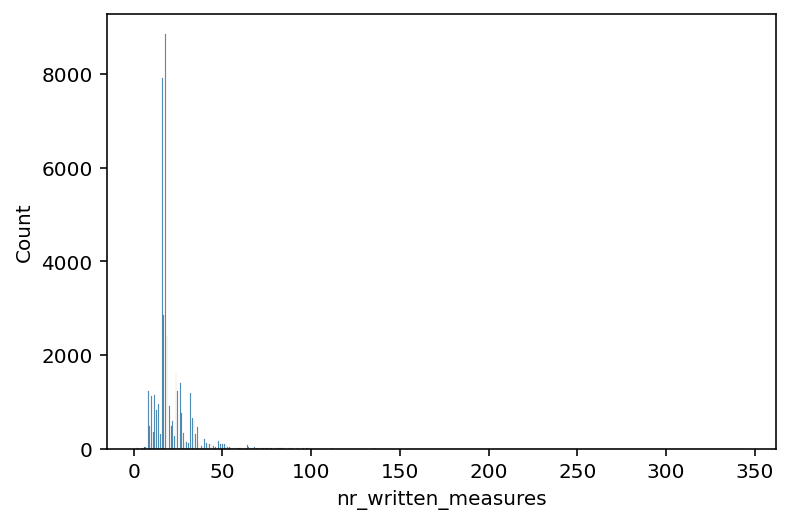

In [134]:
sns.histplot(x="nr_written_measures", data=section_features)

<AxesSubplot:xlabel='has_pickup', ylabel='count'>

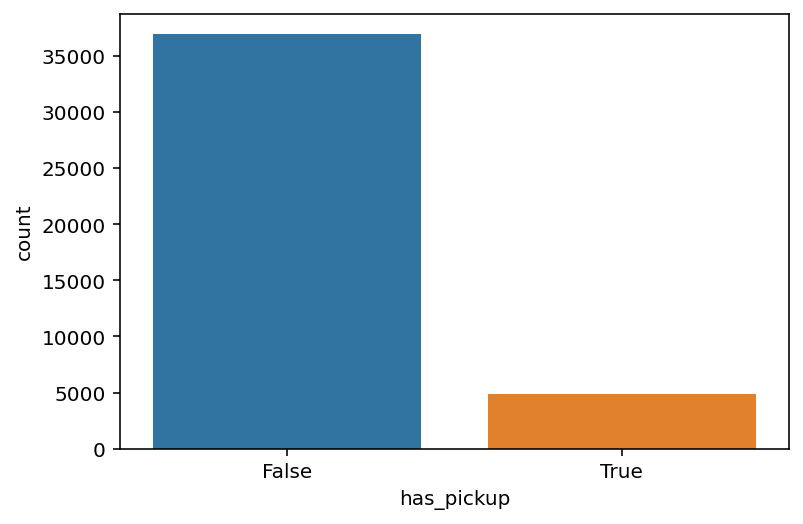

In [135]:
sns.countplot(x="has_pickup", data=section_features)

In [136]:
# sns.countplot(x="has_pickup", data=simplified_section_features)

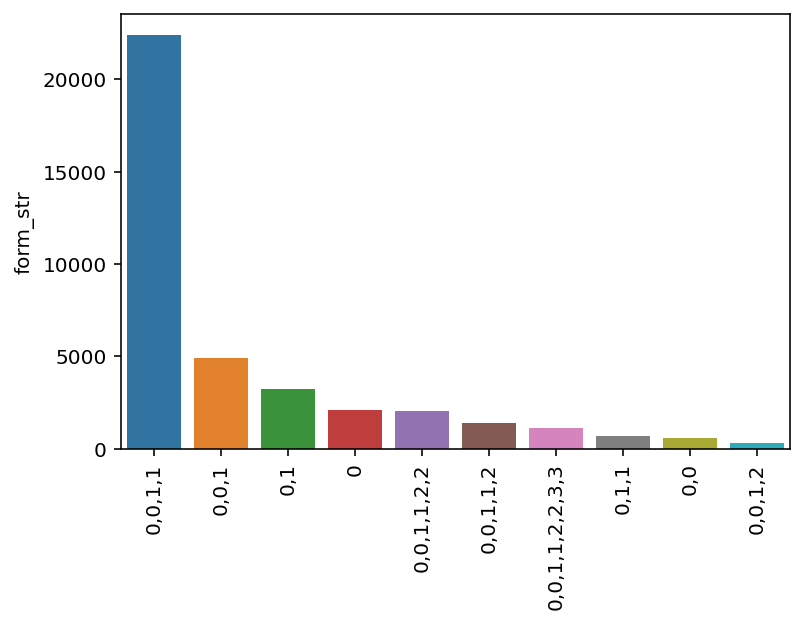

In [137]:
sns.barplot(
    x=section_features["form_str"].value_counts()[:10].index,
    y=section_features["form_str"].value_counts()[:10]
)
plt.xticks(rotation="vertical");

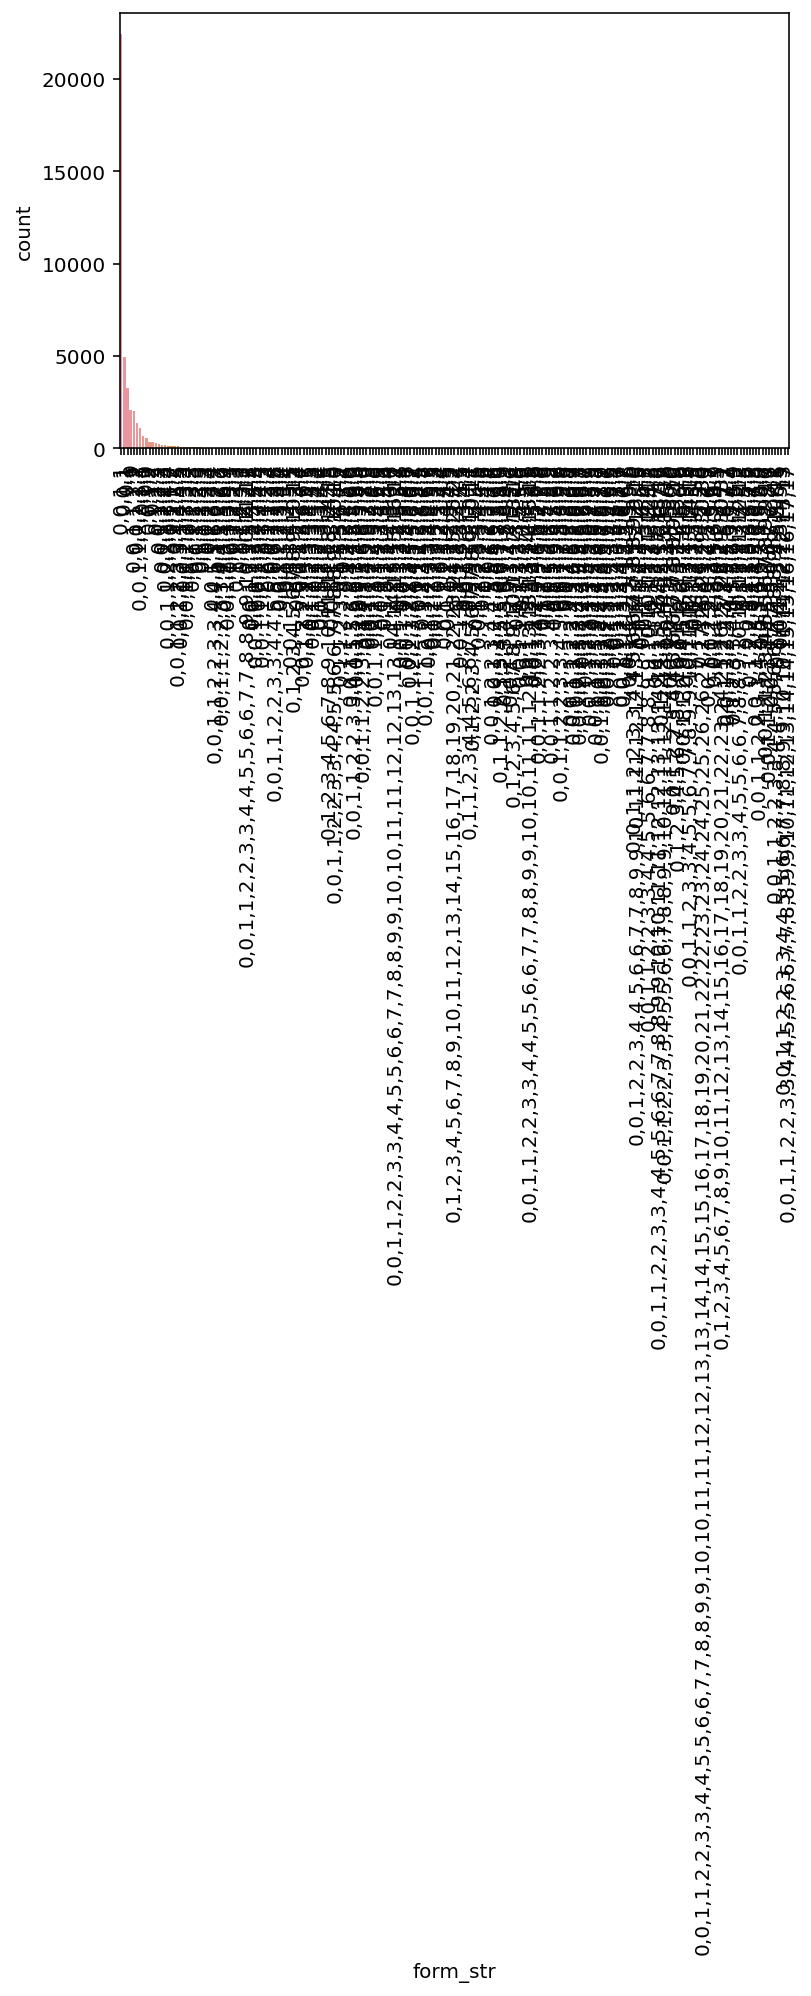

In [138]:
sns.countplot(
    x="form_str",
    data=section_features,
    order=section_features["form_str"].value_counts().index
)
plt.xticks(rotation="vertical");

In [190]:
# sns.countplot(x="form_str", data=simplified_section_features)
# plt.xticks(rotation="vertical");

In [191]:
# plt.figure(figsize=(12, 4))
# sns.countplot(
#     x="value",
#     hue="variable",
#     data=pd.concat(
#         [
#             section_features["form_str"],
#             simplified_section_features["form_str"]
#         ],
#         keys=["normal", "simple"],
#         axis=1,
#     ).melt()
# )
# plt.xticks(rotation="vertical")
# plt.show()

In [81]:
section_features

,nr_written_measures,has_pickup,form_str,mean_anacrusis_balance,mean_section_len_is_divisible_by_4,section_info
tune_idx,,,,,,
0,18,False,"0,0,1,1",1.0,1.0,has_anacrusis anacrusis_balance section_l...
1,18,False,"0,0,1,1",1.0,1.0,has_anacrusis anacrusis_balance section_l...
2,18,False,"0,0,1,1",1.0,1.0,has_anacrusis anacrusis_balance section_l...
3,26,True,"0,0,1,1,2,2",NaN,1.0,has_anacrusis anacrusis_balance section_le...
4,18,False,"0,0,1,1",NaN,1.0,has_anacrusis anacrusis_balance section_le...
...,...,...,...,...,...,...
995,19,False,"0,0,1,1",0.5,1.0,has_anacrusis anacrusis_balance section_l...
996,20,True,"0,0,1,1",0.5,1.0,has_anacrusis anacrusis_balance section_l...
997,16,False,"0,0,1,1",NaN,1.0,has_anacrusis anacrusis_balance section_le...


In [82]:
section_features[section_features["mean_section_len_is_divisible_by_4"] != 1]

,nr_written_measures,has_pickup,form_str,mean_anacrusis_balance,mean_section_len_is_divisible_by_4,section_info
tune_idx,,,,,,
8,20,False,"0,0,1,1",1.00,0.500000,has_anacrusis anacrusis_balance section_l...
33,48,False,"0,1,2",0.00,0.000000,has_anacrusis anacrusis_balance section_l...
34,16,False,0,0.00,0.000000,has_anacrusis anacrusis_balance section_l...
53,19,False,"0,1,1,2,3,3",NaN,0.000000,has_anacrusis anacrusis_balance section_le...
54,25,False,"0,1,1,2",NaN,0.333333,has_anacrusis anacrusis_balance section_le...
...,...,...,...,...,...,...
912,36,False,"0,0,1,1,2,3,4",NaN,0.800000,has_anacrusis anacrusis_balance section_le...
913,22,False,"0,0,1,1,2",0.75,0.666667,has_anacrusis anacrusis_balance section_l...
914,20,False,"0,0,1,1",NaN,0.000000,has_anacrusis anacrusis_balance section_le...


In [83]:
section_features[section_features["mean_section_len_is_divisible_by_4"] != 1].iloc[:10]

,nr_written_measures,has_pickup,form_str,mean_anacrusis_balance,mean_section_len_is_divisible_by_4,section_info
tune_idx,,,,,,
8,20,False,"0,0,1,1",1.0,0.500000,has_anacrusis anacrusis_balance section_l...
33,48,False,"0,1,2",0.0,0.000000,has_anacrusis anacrusis_balance section_l...
34,16,False,0,0.0,0.000000,has_anacrusis anacrusis_balance section_l...
53,19,False,"0,1,1,2,3,3",NaN,0.000000,has_anacrusis anacrusis_balance section_le...
54,25,False,"0,1,1,2",NaN,0.333333,has_anacrusis anacrusis_balance section_le...
59,10,False,"0,1,1",NaN,0.500000,has_anacrusis anacrusis_balance section_le...
64,17,False,"0,1",0.0,0.000000,has_anacrusis anacrusis_balance section_l...
72,16,False,"0,1",0.0,0.000000,has_anacrusis anacrusis_balance section_l...
85,19,False,"0,0,1,1",1.0,0.500000,has_anacrusis anacrusis_balance section_l...


In [85]:
# Music21 parse error? Misspecification of the 2nd repeat?
idx = 8
print(tunes[idx].abc_data)
print(section_features.loc[idx])
display(section_features.loc[idx, "section_info"])
part = music21.converter.parse(tunes[idx].abc_data, format="abc").parts[0]
pprint.pprint(get_section_information(part))
part.show("text")

X: 9
T: Cooley's
Z: eamonn barr
S: https://thesession.org/tunes/1#setting24552
R: reel
M: 4/4
L: 1/8
K: Edor
|:D2|EBBA B2 EB|B2 AB dBAG|FED AD BDAD|FEDAD BAGF|
EBBA B2 EB|B2 AB defg|afec dBAF|DEFD E2:|
|:gf|eB B2 efge|eB B2 gedB|A2 FA DAFA|A2 FA defg|
eB B2 eBgF|eB B2 defg|afec dBAF|DEFD E2:|
nr_written_measures                                                                  20
has_pickup                                                                        False
form_str                                                                        0,0,1,1
mean_anacrusis_balance                                                              1.0
mean_section_len_is_divisible_by_4                                                  0.5
section_info                             has_anacrusis  anacrusis_balance  section_l...
Name: 8, dtype: object


,has_anacrusis,anacrusis_balance,section_length,section_len_is_divisible_by_4
0,True,1.0,10,False
1,True,1.0,8,True


[{'how_many': 2,
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'measures': [<music21.stream.Measure 0 offset=0.0>,
               <music21.stream.Measure 1 offset=1.0>,
               <music21.stream.Measure 2 offset=5.0>,
               <music21.stream.Measure 3 offset=9.0>,
               <music21.stream.Measure 4 offset=13.0>,
               <music21.stream.Measure 5 offset=13.5>,
               <music21.stream.Measure 6 offset=17.5>,
               <music21.stream.Measure 7 offset=18.0>,
               <music21.stream.Measure 8 offset=22.0>,
               <music21.stream.Measure 9 offset=26.0>,
               <music21.stream.Measure 10 offset=30.0>]},
 {'how_many': 2,
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0, 0],
  'measures': [<music21.stream.Measure 11 offset=33.0>,
               <music21.stream.Measure 12 offset=34.0>,
               <music21.stream.Measure 13 offset=38.0>,
               <music21.stream.Measure 14 offset=42.0>,
               <music21.stre

In [111]:
# Genuinely weird - probably a 2 part tune
idx = 49
print(tunes[idx].abc_data)
print(section_features.loc[idx])
display(section_features.loc[idx, "section_info"])
part = music21.converter.parse(tunes[idx].abc_data, format="abc").parts[0]
pprint.pprint(get_section_information(part))
part.show("text")

T: Big John McNeil
M: 4/4
L: 1/8
K: Amaj
a | e>A A/A/A  a>Ac<a | c/d/e =g>d  B>GG>f |e | a/g/f e>A  a>Ac<a | =g/f/e d>G  g>GB<g |
nr_written_measures                                                                   6
has_pickup                                                                        False
form_str                                                                              0
mean_anacrusis_balance                                                              0.0
mean_section_len_is_divisible_by_4                                                  0.0
section_info                             has_anacrusis  anacrusis_balance  section_l...
Name: 49, dtype: object


,has_anacrusis,anacrusis_balance,section_length,section_len_is_divisible_by_4
0,True,0.0,5,False


[{'how_many': 1,
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0],
  'measures': [<music21.stream.Measure 0 offset=0.0>,
               <music21.stream.Measure 1 offset=0.5>,
               <music21.stream.Measure 2 offset=4.5>,
               <music21.stream.Measure 3 offset=8.5>,
               <music21.stream.Measure 4 offset=9.0>,
               <music21.stream.Measure 5 offset=13.0>]}]
{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of A major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note A>
{0.5} <music21.stream.Measure 1 offset=0.5>
    {0.0} <music21.note.Note E>
    {0.75} <music21.note.Note A>
    {1.0} <music21.note.Note A>
    {1.25} <music21.note.Note A>
    {1.5} <music21.note.Note A>
    {2.0} <music21.note.Note A>
    {2.75} <music21.note.Note A>
    {3.0} <music21.note.Note C#>
    {3.25} <music21.note.Note A>
{4.5} <music21.stream.Measure 2 offset=4.5>
    {0.0} <music21.note.Note C#>
    

In [110]:
# Genuinely weird - looks cut off, but also, first section should be len 4, but this is due to a music21 read error
idx = 47
print(tunes[idx].abc_data)
print(section_features.loc[idx])
display(section_features.loc[idx, "section_info"])
part = music21.converter.parse(tunes[idx].abc_data, format="abc").parts[0]
pprint.pprint(get_section_information(part))
part.show("text")

T: Hawthorn Bush, The
M: 4/4
L: 1/8
K: Gmaj
|: G2 Bd e2 dB | GABG AGEF | G2 Bd e2 dB |[1 cAdA cAFA |[2 cABG EG G2 || |: f<aag fdde | fdag fd d2 |
nr_written_measures                                                                   7
has_pickup                                                                        False
form_str                                                                            0,1
mean_anacrusis_balance                                                              NaN
mean_section_len_is_divisible_by_4                                                  0.0
section_info                             has_anacrusis anacrusis_balance  section_le...
Name: 47, dtype: object


,has_anacrusis,anacrusis_balance,section_length,section_len_is_divisible_by_4
0,False,None,5,False
1,False,None,2,False


[{'how_many': 1,
  'measure_repeat_nr': [0, 0, 0, 1, 1],
  'measures': [<music21.stream.Measure 0 offset=0.0>,
               <music21.stream.Measure 1 offset=4.0>,
               <music21.stream.Measure 2 offset=8.0>,
               <music21.stream.Measure 3 offset=12.0>,
               <music21.stream.Measure 4 offset=16.0>]},
 {'how_many': 1,
  'measure_repeat_nr': [0, 0],
  'measures': [<music21.stream.Measure 5 offset=20.0>,
               <music21.stream.Measure 6 offset=24.0>]}]
{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.bar.Repeat direction=start>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note G>
    {1.0} <music21.note.Note B>
    {1.5} <music21.note.Note D>
    {2.0} <music21.note.Note E>
    {3.0} <music21.note.Note D>
    {3.5} <music21.note.Note B>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 3 offset=12.0><music21.stream.Measure 4 offs

In [105]:
# Genuinely weird - 8 followed by a 6: https://thesession.org/tunes/10002
idx = 23
print(tunes[idx].abc_data)
print(section_features.loc[idx])
display(section_features.loc[idx, "section_info"])
part = music21.converter.parse(tunes[idx].abc_data, format="abc").parts[0]
pprint.pprint(get_section_information(part))
part.show("text")

T: Mogi Laddyr
M: 4/4
L: 1/8
K: Dmaj
d>efd gfge|defd gecA|defe/d/ gfga|geAc d2d2|
d>efd gfge|defd gecA|defe/d/ gfga|geAc d2df/g/|
|:a>baf gage|fgfd gedc| defd gfge|
defd gecA|def/e/f/d/ gfga|geAc d2df/g/:|
nr_written_measures                                                                  14
has_pickup                                                                        False
form_str                                                                          0,1,1
mean_anacrusis_balance                                                              NaN
mean_section_len_is_divisible_by_4                                                  0.5
section_info                             has_anacrusis anacrusis_balance  section_le...
Name: 23, dtype: object


,has_anacrusis,anacrusis_balance,section_length,section_len_is_divisible_by_4
0,False,None,8,True
1,False,None,6,False


[{'how_many': 1,
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0],
  'measures': [<music21.stream.Measure 0 offset=0.0>,
               <music21.stream.Measure 1 offset=4.0>,
               <music21.stream.Measure 2 offset=8.0>,
               <music21.stream.Measure 3 offset=12.0>,
               <music21.stream.Measure 4 offset=16.0>,
               <music21.stream.Measure 5 offset=20.0>,
               <music21.stream.Measure 6 offset=24.0>,
               <music21.stream.Measure 7 offset=28.0>]},
 {'how_many': 2,
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0],
  'measures': [<music21.stream.Measure 8 offset=32.0>,
               <music21.stream.Measure 9 offset=36.0>,
               <music21.stream.Measure 10 offset=40.0>,
               <music21.stream.Measure 11 offset=44.0>,
               <music21.stream.Measure 12 offset=48.0>,
               <music21.stream.Measure 13 offset=52.0>]}]
{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.

In [104]:
# Genuinely weird - looks like 3 x 3 sections of length 4 (with an anacrusis)
idx = 22
print(tunes[idx].abc_data)
print(section_features.loc[idx])
display(section_features.loc[idx, "section_info"])
part = music21.converter.parse(tunes[idx].abc_data, format="abc").parts[0]
pprint.pprint(get_section_information(part))
part.show("text")

T: Three Half Tunes
M: 6/8
L: 1/8
K: Dmaj
D>D d>c | (B>A) ((3GFE) | ((3FGA) (B>A) | ((3FGA) B>A | | D>D d>c | ((3Bcd) ((3FGB) | A>d A>F | ((3EFG) ((3FED) | | ((3DFA) d>c | ((3Bcd) ((3GAB) | A>d ((3AGF) | ((3EFG) ((3FED) :||
nr_written_measures                                                                  12
has_pickup                                                                        False
form_str                                                                            0,0
mean_anacrusis_balance                                                              0.0
mean_section_len_is_divisible_by_4                                                  0.0
section_info                             has_anacrusis  anacrusis_balance  section_l...
Name: 22, dtype: object


,has_anacrusis,anacrusis_balance,section_length,section_len_is_divisible_by_4
0,True,0.0,11,False


[{'how_many': 2,
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'measures': [<music21.stream.Measure 0 offset=0.0>,
               <music21.stream.Measure 1 offset=2.0>,
               <music21.stream.Measure 2 offset=4.0>,
               <music21.stream.Measure 3 offset=6.0>,
               <music21.stream.Measure 4 offset=8.0>,
               <music21.stream.Measure 5 offset=10.0>,
               <music21.stream.Measure 6 offset=12.0>,
               <music21.stream.Measure 7 offset=14.0>,
               <music21.stream.Measure 8 offset=16.0>,
               <music21.stream.Measure 9 offset=18.0>,
               <music21.stream.Measure 10 offset=20.0>,
               <music21.stream.Measure 11 offset=22.0>]}]
{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of D major>
    {0.0} <music21.meter.TimeSignature 6/8>
    {0.0} <music21.note.Note D>
    {0.75} <music21.note.Note D>
    {1.0} <music21.note.Note D>
   

In [492]:
# legit has too many notes in bar 5 `FEDAD BAGF`
idx = 8
print(tunes[idx].abc_data)
print(section_features.loc[idx])
print(section_features.loc[idx, "section_info"])
part = music21.converter.parse(tunes[idx].abc_data, format="abc").parts[0]
pprint.pprint(get_section_information(part))
part.show("text")

T: Cooley's
M: 4/4
L: 1/8
K: Edor
|:D2|EBBA B2 EB|B2 AB dBAG|FED AD BDAD|FEDAD BAGF|
EBBA B2 EB|B2 AB defg|afec dBAF|DEFD E2:|
|:gf|eB B2 efge|eB B2 gedB|A2 FA DAFA|A2 FA defg|
eB B2 eBgF|eB B2 defg|afec dBAF|DEFD E2:|
nr_written_measures                                                                  20
has_pickup                                                                        False
form_str                                                                        0,0,1,1
mean_anacrusis_balance                                                              1.0
mean_section_len_is_divisible_by_4                                                  0.5
section_info                             has_anacrusis  anacrusis_balance  section_l...
Name: 8, dtype: object
   has_anacrusis  anacrusis_balance  section_length  \
0           True                1.0              10   
1           True                1.0               8   

   section_len_is_divisible_by_4  
0                          Fa

In [464]:
idx = np.random.choice(section_features.index)
print(tunes[idx].abc_data)
print(section_features.loc[idx])
print(pd.DataFrame(section_features.loc[idx, "section_info"]))
part = music21.converter.parse(tunes[idx].abc_data, format="abc").parts[0]
pprint.pprint(get_section_information(part))
part.show("text")

T: Paddy On The Landfill
M: 4/4
L: 1/8
K: Gdor
G,A,B,D G4 | AGFD G3 E | F2 AF BFAF | BAGF GFDF |G2 BG AGBG | F2 AF BFAF | BAGF DFGA | BcAB G4 :|g2 dg fgdg | /g/g/g dg fdcA | g2 dg fgdg | gabg agfd |g2 dg fgdg | /g/g/g dg fdcA | BAGF DFGA | BcAB G4 :|
nr_written_measures                                                   16
has_pickup                                                         False
form_str                                                         0,0,1,1
section_info           [{'has_anacrusis': False, 'anacrusis_balance':...
Name: 382, dtype: object
   has_anacrusis anacrusis_balance  section_length  \
0          False              None               8   
1          False              None               8   

   section_len_is_divisible_by_4  
0                           True  
1                           True  
[{'how_many': 2,
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0],
  'measures': [<music21.stream.Measure 0 offset=0.0>,
               <music21.stream.Measure 1 off

In [387]:
search_str = """T: Crooked Still
M: 4/4
L: 1/8
K: Dmaj
|:GBdf efdB|dBf2 eddf|gBdf efdB|dafe edd2||"""
[idx for idx, abc in enumerate(abc_strings) if search_str in abc] 

[251]

In [388]:
idx = 251
print(tunes[idx].abc_data)
print(section_features.loc[idx])
part = music21.converter.parse(tunes[idx].abc_data, format="abc").parts[0]
pprint.pprint(get_section_information(part))
part.show("text")

T: Crooked Still
M: 4/4
L: 1/8
K: Dmaj
|:GBdf efdB|dBf2 eddf|gBdf efdB|dafe edd2||GBdf efdB|dBf2 ed(3Bcd|affe edBd-|dfed d3z:||:DGBd a2gf-|f2Bd a2gf-|f2Bd f2ed|deA2 ABd2||DGBd a2gf-|f2Bd a2gf-|f2Bd f2ed|deA2 ABd2:|
has_pickup          False
form_str      0,1,1,2,3,3
Name: 251, dtype: object
[{'how_many': 2,
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0],
  'measures': [<music21.stream.Measure 0 offset=0.0>,
               <music21.stream.Measure 1 offset=4.0>,
               <music21.stream.Measure 2 offset=8.0>,
               <music21.stream.Measure 3 offset=12.0>,
               <music21.stream.Measure 4 offset=16.0>,
               <music21.stream.Measure 5 offset=20.0>,
               <music21.stream.Measure 6 offset=24.0>,
               <music21.stream.Measure 7 offset=28.0>]},
 {'how_many': 2,
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0],
  'measures': [<music21.stream.Measure 8 offset=32.0>,
               <music21.stream.Measure 9 offset=36.0>,
               <music21.str

In [389]:
idx = 161
print(tunes[idx].abc_data)
print(section_features.loc[idx])
part = music21.converter.parse(tunes[idx].abc_data, format="abc").parts[0]
pprint.pprint(get_section_information(part))
part.show("text")

T: Genetic Hambo, The
M: 3/4
L: 1/8
K: Dmaj
A2|:d2f2a2|ga b2g2|cd eg fe|dc dfa2|
d2f2a2|ga b2 g2|cd eg fe|1d2d4:|2d2d2EE||
K:Amaj
|:E2A2EE|E2B2EE|E2Ac dc|BA GF EE|
E2 A2EE|E2B2EE|A2ce dB |1A2 A,2 EE:|2A2 A,2||
K:DMaj
has_pickup       True
form_str      0,0,1,1
Name: 161, dtype: object
[{'how_many': 1,
  'measure_repeat_nr': [0],
  'measures': [<music21.stream.Measure 0 offset=0.0>]},
 {'how_many': 2,
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 1, 2],
  'measures': [<music21.stream.Measure 1 offset=1.0>,
               <music21.stream.Measure 2 offset=4.0>,
               <music21.stream.Measure 3 offset=7.0>,
               <music21.stream.Measure 4 offset=10.0>,
               <music21.stream.Measure 5 offset=13.0>,
               <music21.stream.Measure 6 offset=16.0>,
               <music21.stream.Measure 7 offset=19.0>,
               <music21.stream.Measure 8 offset=22.0>,
               <music21.stream.Measure 9 offset=25.0>]},
 {'how_many': 2,
  'measure_repeat_nr': [0, 0, 0, 

In [356]:
idx = 996
print(tunes[idx].abc_data)
get_section_information(music21.converter.parse(tunes[idx].abc_data, format="abc").parts[0])

T: Alborada Antiga De Ourense
M: 4/4
L: 1/8
K: Dmaj
DEFG |: ~A2GF E2D2 | D/E/DC2 CDEF | ~G2AG F2E2 | ~A2D2 DEFG |A2GF E2D2 | D/E/DC2 CDEF | GAGF E2A2 |1 D3A DEFG :|2 D4- D4 ||~E2EC D2E2 | ~F2FD E2F2 | ~G2GE F2G2 | A4 D4 |~E2EC D2E2 | ~F2FD E2F2 | ~G2GE F2G2 | A4- A4 ||BAGF EFGB | A4- A4 | BAGF EFGB | A4- A4 |B2BA c2cA | d4- d3A | B2AB c2Bc | d4- d3A ||d2cB ABcd | BcBA GABc | ABAG FGAB | GAGF EFGA |FGFE DEFG | EFED CDEF | D4- D2A2 | D4- D2A2 |D4- D2A2 | D2A2 D2A2 | D4- D4- | D2A2 DEFG ||


[{'measures': [<music21.stream.Measure 0 offset=0.0>],
  'measure_repeat_nr': [0],
  'how_many': 1},
 {'measures': [<music21.stream.Measure 1 offset=2.0>,
   <music21.stream.Measure 2 offset=6.0>,
   <music21.stream.Measure 3 offset=10.0>,
   <music21.stream.Measure 4 offset=14.0>,
   <music21.stream.Measure 5 offset=18.0>,
   <music21.stream.Measure 6 offset=22.0>,
   <music21.stream.Measure 7 offset=26.0>,
   <music21.stream.Measure 8 offset=30.0>,
   <music21.stream.Measure 9 offset=34.0>],
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 1, 2],
  'how_many': 2},
 {'measures': [<music21.stream.Measure 10 offset=38.0>,
   <music21.stream.Measure 11 offset=42.0>,
   <music21.stream.Measure 12 offset=46.0>,
   <music21.stream.Measure 13 offset=50.0>,
   <music21.stream.Measure 14 offset=54.0>,
   <music21.stream.Measure 15 offset=58.0>,
   <music21.stream.Measure 16 offset=62.0>,
   <music21.stream.Measure 17 offset=66.0>],
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0],
  'how_many': 1},

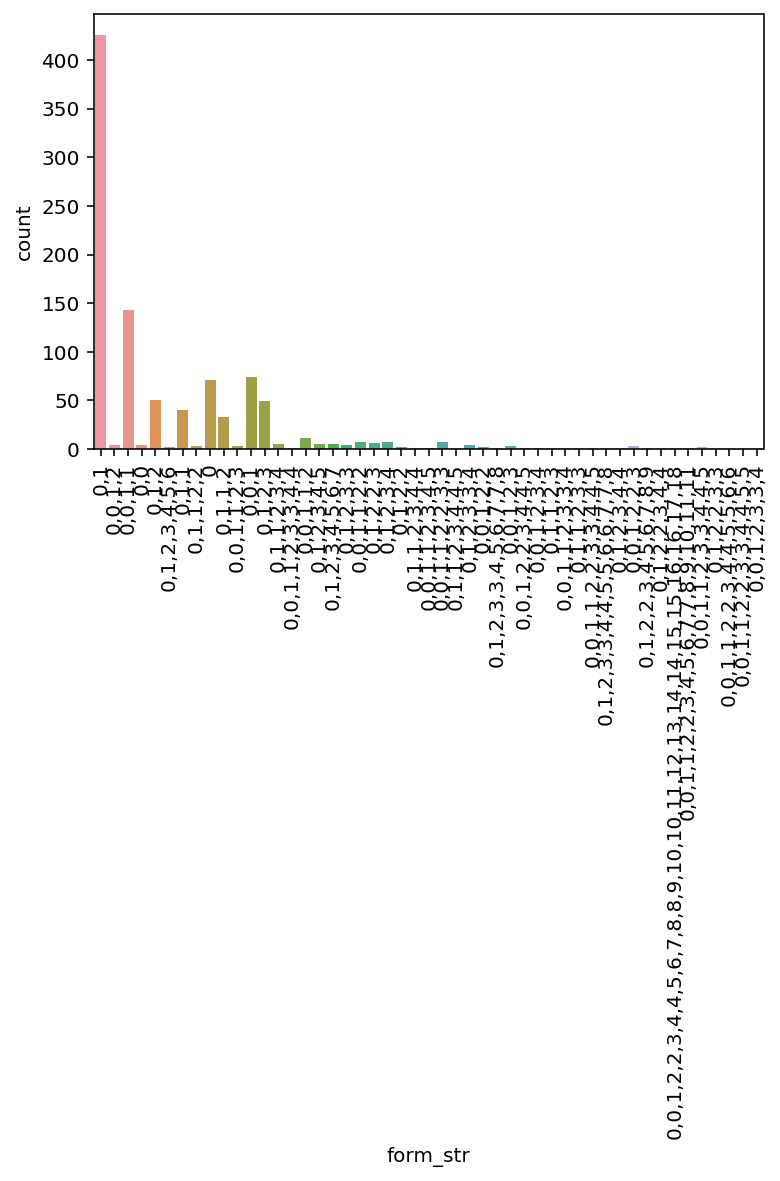

In [293]:
sns.countplot(x="form_str", data=section_features)
plt.xticks(rotation="vertical");

In [298]:
print(tunes[3].abc_data)

T: Cooley's
M: 4/4
L: 1/8
K: Edor
D |: EBBA B3 B | B2 AB dBAD | (3FED AD BDAD | (3FED A=c BAFD |
EBBA  B3 B | B2 AB defg | afec dBAF |1 EGFD E3  D :|2 EGFD E3 d ||
|: eB (3BBB efgf | eB (3BBB fedB | (3ABA FB (3ABA FB | ADFA Bcdf |
eB (3BBB efgf | eB (3BBB fedB | (3ABA FB dfec | dBAF EFGB :|
|: eB (3BBB eBfB | eB (3BBB fedc | BE (3EEE BEdE | BE (3BBB BAFB |
eB (3BBB eBfB | eB (3BBB fecA | d3 e fdec | dBAF EFGB :|


In [300]:
get_section_information(music21.converter.parse(tunes[3].abc_data, format="abc").parts[0])

[{'measures': [<music21.stream.Measure 0 offset=0.0>],
  'measure_repeat_nr': [0],
  'how_many': 1},
 {'measures': [<music21.stream.Measure 1 offset=0.5>,
   <music21.stream.Measure 2 offset=4.5>,
   <music21.stream.Measure 3 offset=8.5>,
   <music21.stream.Measure 4 offset=12.5>,
   <music21.stream.Measure 5 offset=16.5>,
   <music21.stream.Measure 6 offset=20.5>,
   <music21.stream.Measure 7 offset=24.5>,
   <music21.stream.Measure 8 offset=28.5>,
   <music21.stream.Measure 9 offset=32.5>],
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 1, 2],
  'how_many': 2},
 {'measures': [<music21.stream.Measure 10 offset=36.5>,
   <music21.stream.Measure 11 offset=40.5>,
   <music21.stream.Measure 12 offset=44.5>,
   <music21.stream.Measure 13 offset=48.5>,
   <music21.stream.Measure 14 offset=52.5>,
   <music21.stream.Measure 15 offset=56.5>,
   <music21.stream.Measure 16 offset=60.5>,
   <music21.stream.Measure 17 offset=64.5>],
  'measure_repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0],
  'how_many': 1},


In [146]:
abc_data = """
T: Cooley's
M: 4/4
L: 1/8
K: Edor
|:D2|EBBA B2 EB|B2 AB dBAG|FDAD BDAD|FDAD dAFD|
EBBA B2 EB|B2 AB defg|afec dBAF|DEFD E2:|
|:gf|eB B2 efge|eB B2 gedB|A2 FA DAFA|A2 FA defg|
eB B2 eBgB|eB B2 defg|afec dBAF|DEFD E2:|
"""
score = music21.converter.parse(abc_data, format="abc")
part = score.parts[0]
# part.show("text")
get_section_information(part)

[{'measures': [], 'repeat_nr': []},
 {'measures': [<music21.stream.Measure 0 offset=0.0>,
   <music21.stream.Measure 1 offset=1.0>,
   <music21.stream.Measure 2 offset=5.0>,
   <music21.stream.Measure 3 offset=9.0>,
   <music21.stream.Measure 4 offset=13.0>,
   <music21.stream.Measure 5 offset=17.0>,
   <music21.stream.Measure 6 offset=21.0>,
   <music21.stream.Measure 7 offset=25.0>,
   <music21.stream.Measure 8 offset=29.0>],
  'repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0, 0]},
 {'measures': [<music21.stream.Measure 9 offset=32.0>,
   <music21.stream.Measure 10 offset=33.0>,
   <music21.stream.Measure 11 offset=37.0>,
   <music21.stream.Measure 12 offset=41.0>,
   <music21.stream.Measure 13 offset=45.0>,
   <music21.stream.Measure 14 offset=49.0>,
   <music21.stream.Measure 15 offset=53.0>,
   <music21.stream.Measure 16 offset=57.0>,
   <music21.stream.Measure 17 offset=61.0>],
  'repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0, 0]}]

In [147]:
abc_data = """
T: Cooley's
M: 4/4
L: 1/8
K: Edor
D |: EBBA B3 B | B2 AB dBAD | (3FED AD BDAD | (3FED A=c BAFD |
EBBA  B3 B | B2 AB defg | afec dBAF |1 EGFD E3  D :|2 EGFD E3 d ||
|: eB (3BBB efgf | eB (3BBB fedB | (3ABA FB (3ABA FB | ADFA Bcdf |
eB (3BBB efgf | eB (3BBB fedB | (3ABA FB dfec | dBAF EFGB :|
|: eB (3BBB eBfB | eB (3BBB fedc | BE (3EEE BEdE | BE (3BBB BAFB |
eB (3BBB eBfB | eB (3BBB fecA | d3 e fdec | dBAF EFGB :|
"""
score = music21.converter.parse(abc_data, format="abc")
part = score.parts[0]
# part.show("text")
get_section_information(part)

[{'measures': [<music21.stream.Measure 0 offset=0.0>], 'repeat_nr': [0]},
 {'measures': [<music21.stream.Measure 1 offset=0.5>,
   <music21.stream.Measure 2 offset=4.5>,
   <music21.stream.Measure 3 offset=8.5>,
   <music21.stream.Measure 4 offset=12.5>,
   <music21.stream.Measure 5 offset=16.5>,
   <music21.stream.Measure 6 offset=20.5>,
   <music21.stream.Measure 7 offset=24.5>,
   <music21.stream.Measure 8 offset=28.5>,
   <music21.stream.Measure 9 offset=32.5>],
  'repeat_nr': [0, 0, 0, 0, 0, 0, 0, 1, 2]},
 {'measures': [<music21.stream.Measure 10 offset=36.5>,
   <music21.stream.Measure 11 offset=40.5>,
   <music21.stream.Measure 12 offset=44.5>,
   <music21.stream.Measure 13 offset=48.5>,
   <music21.stream.Measure 14 offset=52.5>,
   <music21.stream.Measure 15 offset=56.5>,
   <music21.stream.Measure 16 offset=60.5>,
   <music21.stream.Measure 17 offset=64.5>],
  'repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0]},
 {'measures': [<music21.stream.Measure 18 offset=68.5>,
   <music21.stream.Me

[{'measures': [<music21.stream.Measure 0 offset=0.0>], 'repeat_nr': [0]},
 {'measures': [<music21.stream.Measure 1 offset=0.5>,
   <music21.stream.Measure 2 offset=4.5>,
   <music21.stream.Measure 3 offset=8.5>,
   <music21.stream.Measure 4 offset=12.5>,
   <music21.stream.Measure 5 offset=16.5>,
   <music21.stream.Measure 6 offset=20.5>,
   <music21.stream.Measure 7 offset=24.5>,
   <music21.stream.Measure 8 offset=28.5>,
   <music21.stream.Measure 9 offset=32.5>],
  'repeat_nr': [0, 0, 0, 0, 0, 0, 0, 1, 2]},
 {'measures': [<music21.stream.Measure 10 offset=36.5>,
   <music21.stream.Measure 11 offset=40.5>,
   <music21.stream.Measure 12 offset=44.5>,
   <music21.stream.Measure 13 offset=48.5>,
   <music21.stream.Measure 14 offset=52.5>,
   <music21.stream.Measure 15 offset=56.5>,
   <music21.stream.Measure 16 offset=60.5>,
   <music21.stream.Measure 17 offset=64.5>],
  'repeat_nr': [0, 0, 0, 0, 0, 0, 0, 0]},
 {'measures': [<music21.stream.Measure 18 offset=68.5>,
   <music21.stream.Me

In [505]:
[m for m in part][1].getSpannedElements()
[m for m in part][1].number

'1'

'1'

In [501]:
[m for m in part][1].getFirst()

<music21.stream.Measure 8 offset=28.5>

In [496]:
abc_data = """
T: Cooley's
M: 4/4
L: 1/8
K: Edor
D |: EBBA B3 B | B2 AB dBAD | (3FED AD BDAD | (3FED A=c BAFD |
EBBA  B3 B | B2 AB defg | afec dBAF |1 EGFD E3  D :|2 EGFD E3 d ||
|: eB (3BBB efgf | eB (3BBB fedB | (3ABA FB (3ABA FB | ADFA Bcdf |
eB (3BBB efgf | eB (3BBB fedB | (3ABA FB dfec | dBAF EFGB :|
|: eB (3BBB eBfB | eB (3BBB fedc | BE (3EEE BEdE | BE (3BBB BAFB |
eB (3BBB eBfB | eB (3BBB fecA | d3 e fdec | dBAF EFGB :|
"""
score = music21.converter.parse(abc_data, format="abc")
part = score.parts[0]
part.show("text")

{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of E dorian>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note D>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 8 offset=28.5>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 9 offset=32.5>>
{0.5} <music21.stream.Measure 1 offset=0.5>
    {0.0} <music21.bar.Repeat direction=start>
    {0.0} <music21.note.Note E>
    {0.5} <music21.note.Note B>
    {1.0} <music21.note.Note B>
    {1.5} <music21.note.Note A>
    {2.0} <music21.note.Note B>
    {3.5} <music21.note.Note B>
{4.5} <music21.stream.Measure 2 offset=4.5>
    {0.0} <music21.note.Note B>
    {1.0} <music21.note.Note A>
    {1.5} <music21.note.Note B>
    {2.0} <music21.note.Note D>
    {2.5} <music21.note.Note B>
    {3.0} <music21.note.Note A>
    {3.5} <music21.note.Note D>
{8.5} <music21.stream.Measure 3 offset=8.5>
    {0.0} <music21.note.Note F#>
    {0.3333} <musi

In [471]:
print(tunes[0].abc_data)

T: Cooley's
M: 4/4
L: 1/8
K: Edor
|:D2|EBBA B2 EB|B2 AB dBAG|FDAD BDAD|FDAD dAFD|
EBBA B2 EB|B2 AB defg|afec dBAF|DEFD E2:|
|:gf|eB B2 efge|eB B2 gedB|A2 FA DAFA|A2 FA defg|
eB B2 eBgB|eB B2 defg|afec dBAF|DEFD E2:|


In [454]:
idx = 3
part = part_df["part"][idx]

In [461]:
part.show("text")

{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of E dorian>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note D>
{0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 8 offset=0.0>>
{0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 9 offset=0.0>>
{0.5} <music21.stream.Measure 1 offset=0.5>
    {0.0} <music21.bar.Repeat direction=start>
    {0.0} <music21.note.Note E>
    {0.5} <music21.note.Note B>
    {1.0} <music21.note.Note B>
    {1.5} <music21.note.Note A>
    {2.0} <music21.note.Note B>
    {3.5} <music21.note.Note B>
{4.5} <music21.stream.Measure 2 offset=4.5>
    {0.0} <music21.note.Note B>
    {1.0} <music21.note.Note A>
    {1.5} <music21.note.Note B>
    {2.0} <music21.note.Note D>
    {2.5} <music21.note.Note B>
    {3.0} <music21.note.Note A>
    {3.5} <music21.note.Note D>
{8.5} <music21.stream.Measure 3 offset=8.5>
    {0.0} <music21.note.Note F#>
    {0.3333} <music2

In [458]:
# music21.repeat.Expander(part).measureMap(returnType='measureNumber')

In [459]:
# music21.repeat.Expander(part).measureMap()

In [460]:
music21.repeat.RepeatFinder(part.expandRepeats()).getMeasureSimilarityList()

[[],
 [5, 9, 13],
 [10],
 [11],
 [12],
 [9, 13],
 [14],
 [15],
 [],
 [13],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [21, 25, 29],
 [22, 26, 30],
 [27],
 [28],
 [25, 29],
 [26, 30],
 [31],
 [32, 40, 48],
 [29],
 [30],
 [],
 [],
 [],
 [],
 [],
 [40, 48],
 [37, 41, 45],
 [42],
 [43],
 [44],
 [41, 45],
 [46],
 [47],
 [48],
 [45],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [455]:
sections = get_sections(part)
sections

[(0, 1, 2, 3, 4, 5, 6, 7, 8),
 (1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17),
 (10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25),
 (18, 19, 20, 21, 22, 23, 24, 25)]

In [ ]:
form, section_id = label_sections_and_get_form(sections)
part.show("text")

In [430]:

sections

[(0, 1, 2, 3, 4, 5, 6, 7, 8),
 (0, 1, 2, 3, 4, 5, 6, 7, 8),
 (9, 10, 11, 12, 13, 14, 15, 16, 17),
 (9, 10, 11, 12, 13, 14, 15, 16, 17)]

In [431]:
set(sections)

{(0, 1, 2, 3, 4, 5, 6, 7, 8), (9, 10, 11, 12, 13, 14, 15, 16, 17)}

In [434]:
import string

In [437]:
section_id = {}
form = ""
section_nr = 0
for section in sections:
    if section not in section_id:
        section_letter = string.ascii_uppercase[section_nr]
        section_id[section] = section_letter
        section_nr += 1    
    form += section_id[section]
form, section_id

('AABB',
 {(0, 1, 2, 3, 4, 5, 6, 7, 8): 'A', (9, 10, 11, 12, 13, 14, 15, 16, 17): 'B'})

In [423]:
[r for r in part_df["part"][0].getElementsByClass(music21.repeat.RepeatMark)]

[]

In [418]:
rf = music21.repeat.RepeatFinder(part_df["part"][0].expandRepeats())
rf

In [419]:
rf.getSimilarMeasureGroups()

[([0, 1, 2, 3, 4, 5, 6, 7, 8], [9, 10, 11, 12, 13, 14, 15, 16, 17]),
 ([16, 17, 18, 19, 20, 21, 22, 23, 24], [25, 26, 27, 28, 29, 30, 31, 32, 33]),
 ([17, 18, 19, 20, 21, 22, 23, 24, 25], [26, 27, 28, 29, 30, 31, 32, 33, 34]),
 ([18, 19, 20, 21, 22, 23, 24, 25, 26], [27, 28, 29, 30, 31, 32, 33, 34, 35]),
 ([7, 8], [25, 26]),
 ([7, 8], [34, 35]),
 ([16, 17], [34, 35]),
 ([1], [5]),
 ([1], [14]),
 ([5], [10]),
 ([10], [14])]

In [421]:
rf.getMeasureSimilarityList()

[[9],
 [5, 10, 14],
 [11],
 [12],
 [13],
 [10, 14],
 [15],
 [16, 25, 34],
 [17, 26, 35],
 [],
 [14],
 [],
 [],
 [],
 [],
 [],
 [25, 34],
 [26, 35],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [399]:
part_objects["measures"][0]

[<music21.stream.Measure 0 offset=0.0>,
 <music21.stream.Measure 1 offset=1.0>,
 <music21.stream.Measure 2 offset=5.0>,
 <music21.stream.Measure 3 offset=9.0>,
 <music21.stream.Measure 4 offset=13.0>,
 <music21.stream.Measure 5 offset=17.0>,
 <music21.stream.Measure 6 offset=21.0>,
 <music21.stream.Measure 7 offset=25.0>,
 <music21.stream.Measure 8 offset=29.0>,
 <music21.stream.Measure 9 offset=32.0>,
 <music21.stream.Measure 10 offset=33.0>,
 <music21.stream.Measure 11 offset=37.0>,
 <music21.stream.Measure 12 offset=41.0>,
 <music21.stream.Measure 13 offset=45.0>,
 <music21.stream.Measure 14 offset=49.0>,
 <music21.stream.Measure 15 offset=53.0>,
 <music21.stream.Measure 16 offset=57.0>,
 <music21.stream.Measure 17 offset=61.0>]

In [393]:
[x for x in part_objects["measures"][0][0]]

[<music21.bar.Repeat direction=start>,
 <music21.clef.TrebleClef>,
 <music21.key.Key of E dorian>,
 <music21.meter.TimeSignature 4/4>,
 <music21.note.Note D>]

In [408]:
part_objects["measures"][0][0].leftBarline.direction

'start'

In [398]:
[x for x in part_objects["measures"][0][1]]

[<music21.note.Note E>,
 <music21.note.Note B>,
 <music21.note.Note B>,
 <music21.note.Note A>,
 <music21.note.Note B>,
 <music21.note.Note E>,
 <music21.note.Note B>]

In [409]:
part_objects["measures"][0][1].rightBarline

In [385]:
get_measure_info(part_objects["measures"][0])

[(4.0, 1.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 3.0),
 (4.0, 1.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (4.0, 3.0)]

In [380]:
[x for x in part_objects["measures"][0][0]]

[<music21.bar.Repeat direction=start>,
 <music21.clef.TrebleClef>,
 <music21.key.Key of E dorian>,
 <music21.meter.TimeSignature 4/4>,
 <music21.note.Note D>]

In [ ]:
part_df

In [214]:
stream = music21.converter.parse("M:4/4\nL:1/8\nK:C dorian\nCG_e[CG_e]||[K:D] abc|ddDd||\n[ K:C# ]abcdefg|", format="abc")

In [215]:
stream_list = [x for x in stream.flat]
stream_list

 <music21.clef.TrebleClef>,
 <music21.key.Key of C dorian>,
 <music21.meter.TimeSignature 4/4>,
 <music21.note.Note C>,
 <music21.note.Note G>,
 <music21.note.Note E->,
 <music21.chord.Chord C4 G4 E-5>,
 <music21.bar.Barline type=double>,
 <music21.bar.Barline type=double>,
 <music21.note.Note A>,
 <music21.note.Note B->,
 <music21.note.Note C>,
 <music21.note.Note D>,
 <music21.note.Note D>,
 <music21.note.Note D>,
 <music21.note.Note D>,
 <music21.bar.Barline type=double>,
 <music21.bar.Barline type=double>,
 <music21.note.Note A>,
 <music21.note.Note B->,
 <music21.note.Note C>,
 <music21.note.Note D>,
 <music21.note.Note E->,
 <music21.note.Note F>,
 <music21.note.Note G>]

In [222]:
stream_list[0].all()

[]

In [228]:
part = stream.parts[0]
part.show("text")

{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of C dorian>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note C>
    {0.5} <music21.note.Note G>
    {1.0} <music21.note.Note E->
    {1.5} <music21.chord.Chord C4 G4 E-5>
    {2.0} <music21.bar.Barline type=double>
{2.0} <music21.stream.Measure 1 offset=2.0>
    {0.0} <music21.bar.Barline type=double>
    {0.0} <music21.note.Note A>
    {0.5} <music21.note.Note B->
    {1.0} <music21.note.Note C>
{3.5} <music21.stream.Measure 2 offset=3.5>
    {0.0} <music21.note.Note D>
    {0.5} <music21.note.Note D>
    {1.0} <music21.note.Note D>
    {1.5} <music21.note.Note D>
    {2.0} <music21.bar.Barline type=double>
{5.5} <music21.stream.Measure 3 offset=5.5>
    {0.0} <music21.bar.Barline type=double>
    {0.0} <music21.note.Note A>
    {0.5} <music21.note.Note B->
    {1.0} <music21.note.Note C>
    {1.5} <music21.note.Note D>
    {2.0} <music21.note.Note E->
  

[('C dorian', -2)]

In [217]:
with CapturingStdout() as music21_stdout:
    stream.show("text")
print('\n'.join(music21_stdout))

{0.0} <music21.metadata.Metadata object at 0x7f47cb67e5b0>
{0.0} <music21.stream.Part 0x7f47cb9e0130>
    {0.0} <music21.stream.Measure 0 offset=0.0>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of C dorian>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note C>
        {0.5} <music21.note.Note G>
        {1.0} <music21.note.Note E->
        {1.5} <music21.chord.Chord C4 G4 E-5>
        {2.0} <music21.bar.Barline type=double>
    {2.0} <music21.stream.Measure 1 offset=2.0>
        {0.0} <music21.bar.Barline type=double>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note B->
        {1.0} <music21.note.Note C>
    {3.5} <music21.stream.Measure 2 offset=3.5>
        {0.0} <music21.note.Note D>
        {0.5} <music21.note.Note D>
        {1.0} <music21.note.Note D>
        {1.5} <music21.note.Note D>
        {2.0} <music21.bar.Barline type=double>
    {5.5} <music21.stream.Measure 3 offset=5.5>
        {0.0} <music21

In [300]:
part.measures()

TypeError: measures() missing 2 required positional arguments: 'numberStart' and 'numberEnd'

In [218]:
[(x.barDuration, x.duration) for x in stream.parts[0]]

[(<music21.duration.Duration 4.0>, <music21.duration.Duration 2.0>),
 (<music21.duration.Duration 4.0>, <music21.duration.Duration 1.5>),
 (<music21.duration.Duration 4.0>, <music21.duration.Duration 2.0>),
 (<music21.duration.Duration 4.0>, <music21.duration.Duration 3.5>)]

In [184]:
flat_stream = stream.flat

In [185]:
[x for x in flat_stream]

 <music21.clef.TrebleClef>,
 <music21.key.Key of D major>,
 <music21.meter.TimeSignature 4/5>,
 <music21.note.Note C>,
 <music21.note.Note G>,
 <music21.note.Note E->,
 <music21.chord.Chord C4 G4 E-5>,
 <music21.note.Note A>,
 <music21.note.Note B>,
 <music21.note.Note C#>,
 <music21.note.Note D>,
 <music21.note.Note D>,
 <music21.note.Note D>,
 <music21.note.Note D>,
 <music21.bar.Barline type=double>,
 <music21.bar.Barline type=double>,
 <music21.note.Note A>,
 <music21.note.Note B>,
 <music21.note.Note C#>,
 <music21.note.Note D>,
 <music21.note.Note E>,
 <music21.note.Note F#>,
 <music21.note.Note G>,
 <music21.meter.TimeSignature 3/10>,
 <music21.note.Note G>]

In [186]:
len(stream.recurse().getTimeSignatures(returnDefault=False))

2

In [177]:
time_signatures = stream.getTimeSignatures(returnDefault=False)

In [178]:
stream.recurse().hasElementOfClass(music21.chord.Chord)

True

In [219]:
key_signatures = stream.recurse().getKeySignatures()
len(key_signatures)

1

In [ ]:
key_signatures

In [113]:
[x for x in stream.flat.getElementsByClass(music21.chord.Chord)]

[<music21.chord.Chord C4 G4 E-5>]

In [115]:
[x for x in stream.flat.getElementsByClass(music21.meter.TimeSignature)][0]

<music21.meter.TimeSignature 4/4>

In [105]:
tunes_with_chords = [
    tune
    for tune in tqdm(tunes)
    if len([x for x in tune.abc_music21.flat.getElementsByClass(music21.chord.Chord)]) > 0
]

  0%|          | 0/23259 [00:00<?, ?it/s]

In [107]:
len(tunes_with_chords)

497

In [106]:
tune = tunes_with_chords[0]
tune

ABCTune(
    abc_data='T: Cluck Old Hen\nM: 4/4\nL: 1/8\nK: Ador\n|: e2ae g2ag|e2ae d2dd| e2ae g2ag| edc2 A2AA :|\n|: A2A2 [c4e4] |A2A2 [G4B4]| A2AA cAcd| edc2 A2AA :|',
    pianoroll_divisions_per_quarternote=12,
    min_pitch=None,
    min_time=None,
    transpose_semitones=None,
    transpose_to_pitchclass=None,
)

# Tunes to dataframes

In [108]:
score = tune.abc_music21
score

<music21.stream.Score 0x7f46be7674f0>

In [109]:
assert len(score.getElementsByClass(music21.stream.Part)) == 1

In [110]:
objects = [obj for obj in score.flat]

In [111]:
objects[-1].offset

32.0

In [93]:
data = []
for obj in score.flat:
    offset = obj.offset
    duration = obj.duration.quarterLength
    data.append(
        {
            "object": obj,
            "class": type(obj),
            "classname": obj.__class__.__name__,
            "start": offset,
            "duration": duration,
#             "pitch":
        }
    )

In [94]:
df = pd.DataFrame(data)

In [95]:
df

,object,class,classname,start,duration
0,<music21.metadata.Metadata object at 0x7f46bf5...,<class 'music21.metadata.Metadata'>,Metadata,0.0,0.0
1,<music21.bar.Repeat direction=start>,<class 'music21.bar.Repeat'>,Repeat,0.0,0.0
2,<music21.clef.TrebleClef>,<class 'music21.clef.TrebleClef'>,TrebleClef,0.0,0.0
3,E dorian,<class 'music21.key.Key'>,Key,0.0,0.0
4,<music21.meter.TimeSignature 4/4>,<class 'music21.meter.TimeSignature'>,TimeSignature,0.0,0.0
...,...,...,...,...,...
118,<music21.note.Note E>,<class 'music21.note.Note'>,Note,61.5,0.5
119,<music21.note.Note F#>,<class 'music21.note.Note'>,Note,62.0,0.5
120,<music21.note.Note D>,<class 'music21.note.Note'>,Note,62.5,0.5
121,<music21.note.Note E>,<class 'music21.note.Note'>,Note,63.0,1.0


In [88]:
part = score